In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

import time
import ipdb

%matplotlib inline
%matplotlib notebook

地图可以看成一个weighted graph

In [2]:
nodes = pd.read_csv('./data/node.csv')
edges = pd.read_csv('./data/edge.csv')

edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.sqrt(
        (from_node['x'].values[0] - to_node['x'].values[0])**2 + (from_node['y'].values[0] - to_node['y'].values[0])**2
    )

    

In [3]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

<IPython.core.display.Javascript object>


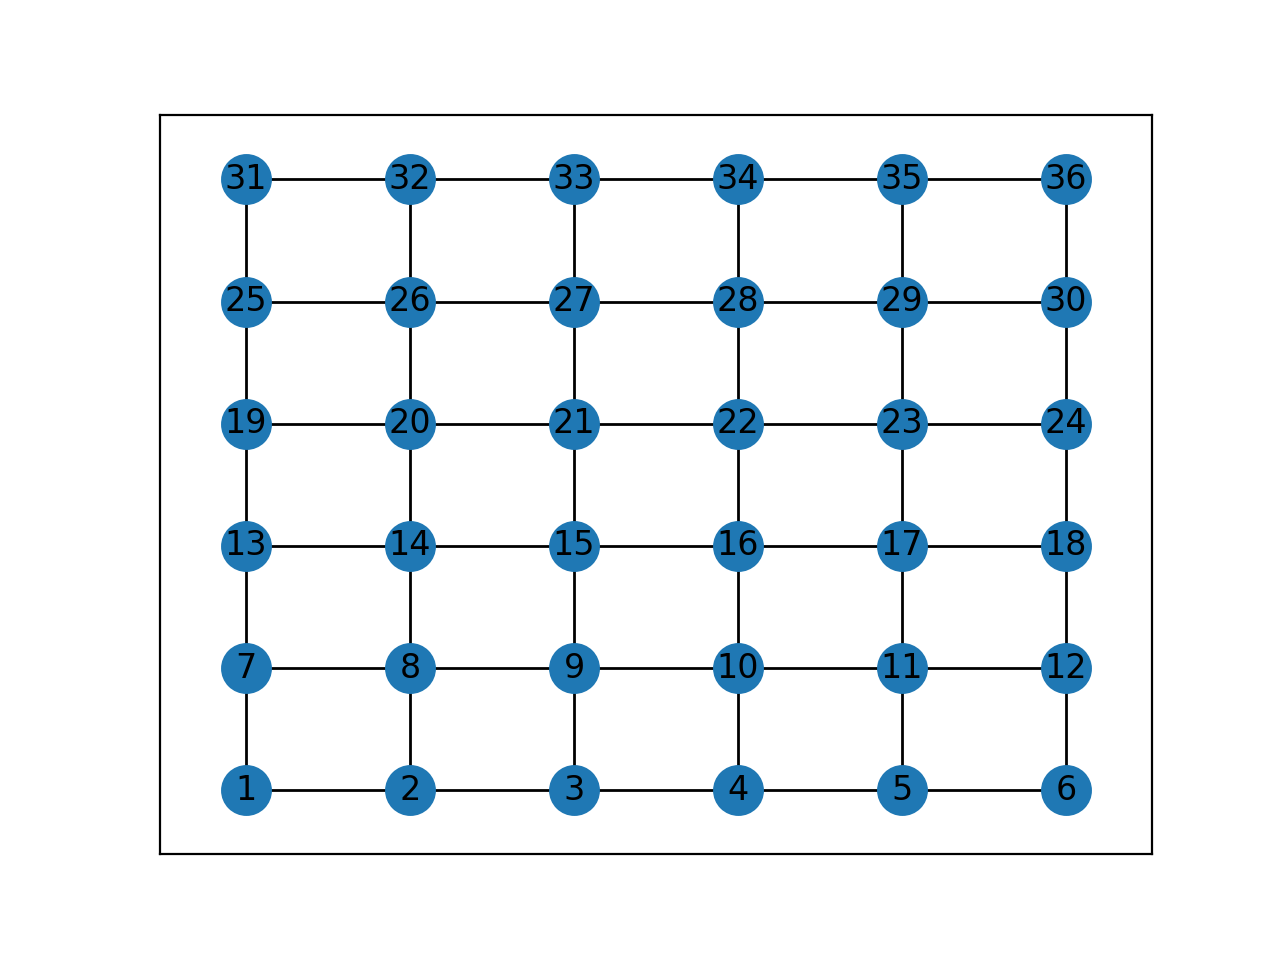

In [4]:
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos)

In [5]:
nx.dijkstra_path(G, 1, 15)

[1, 2, 3, 9, 15]

In [6]:
def get_edge(G, from_node, to_node):
    edge = edges.loc[(edges['from']==from_node)&(edges['to']==to_node)]
    return edge['EdgeName'].iloc[0]

def norm_vec(a):
    return (np.array(a) / np.linalg.norm(np.array(a))).flatten()



def get_adj_node_position(position):
    # return the position of the closest adjacent node
    adj_node_index = (((nodes.iloc[:, 1:] - position )**2).sum(axis=1)).idxmin()
    adj_node = nodes.loc[adj_node_index, 'NodeName']
    adj_node_position = nodes.loc[nodes['NodeName']==adj_node, ['x', 'y']].to_numpy().flatten()
    return adj_node, adj_node_position

    

In [178]:
class rider:
    def __init__(self, config):
        # config is a dictionary
        self.ID = config['ID']                                  # scalar
        self.position = config['initial_position']              # 2-D array
        self.maxspeed = config['maxspeed']                      # scalar
        self.stop_time = 0                                      # scalar, float
        self.state = 'idle'                                     # string 'idle' or 'working' or 'stop'
        self.speed = self.maxspeed / 10
        self.knowledge = None
        self.if_matched = False
        self.customer_nodes = []
        self.matched_orders = []
        self.merchant_node = None
        self.path = None
        self.destination = None
        self.total_time = 0
        self.total_time_rec = []
        
        adj_node, adj_node_position = get_adj_node_position(self.position)
        if np.linalg.norm(adj_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(adj_node_position - self.position)
        
        self.next_node = adj_node
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])

    def update_knowledge(self, knowledge):
        self.knowledge = knowledge
        self.merchant_node = self.knowledge['merchant_node']     # scalar
        self.customer_nodes = self.knowledge['customer_nodes']   # 1-D array
        self.destination = self.merchant_node
        
        adj_node, adj_node_position = get_adj_node_position(self.position)
        if np.linalg.norm(adj_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(adj_node_position - self.position)
        
        self.next_node = adj_node
        # first go to the closest node, then follow the path
        self.path = nx.dijkstra_path(
            self.knowledge['map'], self.next_node, self.destination
        )                                                       # list
        # next node is the last node, then the next next node is random
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)]) if self.next_node==self.path[-1] else self.path[1]

    def move(self, t_resolution, knowledge=None):
        # move one step foward
        if self.state == 'idle':
            travel_distance_mag = self.speed * np.random.rand() * t_resolution
            if self.if_matched:
                self.state = 'working'
                self.speed = self.maxspeed
                self.update_knowledge(knowledge)
                
        elif self.state == 'working':
            travel_distance_mag = self.speed * t_resolution
            self.total_time += t_resolution
        elif self.state == 'stop':
            self.total_time += t_resolution
            self.stop()
            return
        
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        distance_to_next_node = np.linalg.norm(self.position - next_node_position)
        
        if travel_distance_mag < distance_to_next_node:
            self.position = self.position + travel_distance_mag * self.direction
        elif travel_distance_mag >= distance_to_next_node:
            # travel distance greater than the distance to the next node
            self.position = next_node_position
            
            if self.knowledge!=None and self.next_node == self.destination:
                # give up the abundant distance, and stop
                self.stop()
                return
                
            exceed_distance = travel_distance_mag - distance_to_next_node
            
            nextnext_node_position = nodes.loc[nodes['NodeName']==self.nextnext_node, ['x', 'y']].to_numpy().flatten()
            self.direction = norm_vec(nextnext_node_position - next_node_position)
            
            self.position = self.position + exceed_distance * self.direction
            self.next_node = self.nextnext_node
            
            if self.knowledge==None:
                self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
            else:
                if self.next_node == self.destination:
                    # next node is the last node, then the next next node is random
                    self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
                else:
                    self.nextnext_node = self.path[self.path.index(self.next_node) + 1]

    def stop(self):
        # when pickup, delivered, or else
        self.state = 'stop'
        if self.stop_time > 0.1:
            # restart
            self.state = 'working'
            self.stop_time = 0
            # update
            next_destination = self.get_closest_node(self.position)
            if next_destination==None:
                # complete
                self.complete()
                return
            next_dest_i = self.customer_nodes.index(next_destination)
            new_customer_nodes = []
            new_customer_nodes.extend(self.customer_nodes[:next_dest_i])
            new_customer_nodes.extend(self.customer_nodes[next_dest_i+1:])
            self.customer_nodes = new_customer_nodes
            self.matched_orders.append(next_destination)
            self.update(next_destination)
        else:
            self.stop_time = self.stop_time + t_resolution
    
    def complete(self):
        # complete all orders in current bundle
        print('rider %i completed!'%self.ID)
        self.state = 'idle'
        self.destination = None
        self.speed = self.maxspeed / 10
        self.if_matched = False
        self.total_time_rec.append(self.total_time)
        self.total_time = 0
        self.next_node = np.random.choice([i for i in G.neighbors(self.next_node)])
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
        self.customer_nodes = []
        self.matched_orders = []
        return
    
    def update(self, destination):
        # after arriving one destination
        self.destination = destination
        self.path = nx.dijkstra_path(self.knowledge['map'], self.next_node, self.destination)  # next_node is current location
        if len(self.path)==1:
            self.stop()
            return
        self.next_node = self.path[1]
        # if only 2 nodes, then nextnext node is random
        self.nextnext_node = self.path[2] if len(self.path)>2 else np.random.choice([i for i in G.neighbors(self.next_node)])  
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
        
    def get_closest_node(self, from_node):
        # by distance traveled, dijkstra distance
        # from_node: ID or position
        if type(from_node)==int:
            None
        elif type(from_node)==np.ndarray:
            current_node = int(
                nodes.loc[(nodes['x']==from_node[0])&(nodes['y']==from_node[1]), 'NodeName'].values
            )
            from_node = current_node

        distance = 1e10
        closest_node = None
        for i in self.customer_nodes:
            if nx.dijkstra_path_length(self.knowledge['map'], from_node, i) < distance:
                distance = nx.dijkstra_path_length(self.knowledge['map'], from_node, i)
                closest_node = i
        return closest_node


In [179]:
class platform:
    def __init__(self, r, cR, k, t_resolution):
        self.accumulated_order = []
        self.r = r
        self.cR = cR
        self.k = k
        self.t_resolution = t_resolution
    
    def acquire_order(self, q):
        q_t_resolution = q * self.t_resolution
        num_generated_order = np.random.randint(2 * q_t_resolution)
        self.accumulated_order.extend(list(np.random.randint(1, 36, size=num_generated_order)))
    
    def remove_order(self, matched_batches):
        for i in matched_batches.flatten():
            self.accumulated_order.remove(i)
    
    def match(self, idle_rider_IDs):
        n_idle_riders = len(idle_rider_IDs)
        p = 1 - np.exp(-np.pi*r**2* n_idle_riders /25)
        n_orders = len(self.accumulated_order)
        n_batches = n_orders / self.k

        pp = min(p * n_batches / n_idle_riders, 1)
        pp = 0 if np.isnan(pp) else pp

        matched_rider_IDs = np.random.choice(idle_rider_IDs, int(n_idle_riders*pp) )
        
        matched_batches = []
        for i in range(len(matched_rider_IDs)):
            matched_batches.append(np.array(self.accumulated_order)[self.k*i:self.k*(i+1)])
        matched_batches = np.array(matched_batches)
        
        self.remove_order(matched_batches)
        
        self.matched_batches = matched_batches

        return matched_batches, list(matched_rider_IDs)
        

In [180]:
config_set = []
rider_set = []
knowledge_set = []
N = 50
q_bar = 201
r = 2
cR = 8
k = 3
t_resolution = 0.005

A_c = 25

for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.randint(25), np.random.randint(25)]),
        'maxspeed': np.random.randint(50, 70)
    }
    rider_i = rider(config_i)

    knowledge_i = {
        'map': G,
        'merchant_node': 15,
        'customer_nodes': []
    }
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    knowledge_set.append(knowledge_i)
    
plat = platform(r, cR, k, t_resolution)

In [181]:
knowledge_set[0]

{'map': <networkx.classes.graph.Graph at 0x7f99412b9940>,
 'merchant_node': 15,
 'customer_nodes': []}

<IPython.core.display.Javascript object>


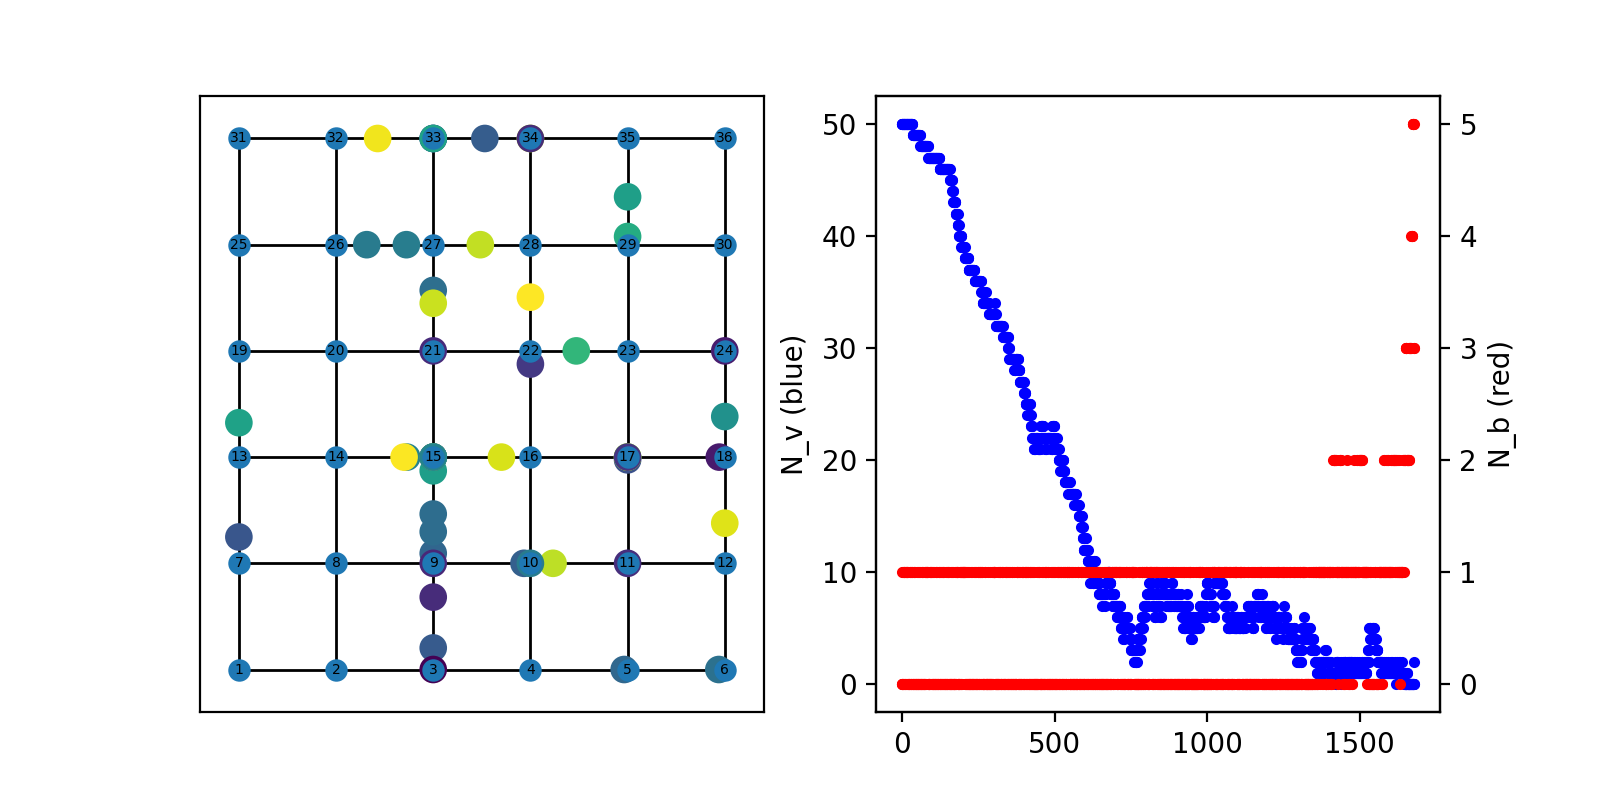

In [182]:
color = np.random.rand(N)

# marking the x-axis and y-axis
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121)
ax.set_xlim(-2, 27)
ax.set_ylim(-2, 27)

ax2 = fig.add_subplot(122)
ax2.set_ylabel('N_v (blue)')

ax3 = ax2.twinx()
ax3.set_ylabel('N_b (red)')
  
nx.draw_networkx(G, pos=pos, ax=ax, node_size=50, font_size=5)

# initializing a line variable

scat = ax.scatter([], [], s=80)
# line,  = ax2.plot([], [], '*')


def animate(n):
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle':
            idle_rider_IDs.append(rider_set[i].ID)
    
    plat.acquire_order(q_bar)
    matched_batches, matched_rider_IDs = plat.match(idle_rider_IDs)
    
    # move
    for i in range(N):
        if rider_set[i].ID in matched_rider_IDs:
            rider_set[i].if_matched = True if len(knowledge_set[i]['customer_nodes'])>0 else False
            batch_index = matched_rider_IDs.index(rider_set[i].ID)
            knowledge_set[i]['customer_nodes'] = list(matched_batches[batch_index, :])
            rider_set[i].move(t_resolution, knowledge_set[i])
        else:
            rider_set[i].move(t_resolution)
    
    scat.set_offsets(
        np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
    )
    scat.set_array(color)
    
    line2 = ax2.plot(n, len(idle_rider_IDs), 'b.')
    line3 = ax3.plot(n, len(plat.accumulated_order)//k, 'r.')
      
    return scat, line2, line3
    

In [183]:
q_bar

201

In [188]:
N * k / 1.5

100.0

In [209]:
for i in range(25):
    print(rider_set[i].total_time_rec)

[1.2599999999999951, 1.314999999999994, 1.3999999999999921, 1.2349999999999957]
[1.5149999999999897, 1.2499999999999953, 1.6699999999999864]
[2.1999999999999753, 1.7549999999999846]
[0.8900000000000007, 1.7699999999999843, 1.5649999999999886]
[1.1799999999999968, 1.7599999999999845, 1.5699999999999885, 1.8649999999999822]
[1.2399999999999956, 1.5649999999999886, 1.2549999999999952, 0.9900000000000008]
[1.214999999999996, 1.5649999999999886, 1.2749999999999948, 1.0100000000000005]
[1.7249999999999852, 1.5249999999999895, 1.1549999999999974]
[1.3999999999999921, 1.0150000000000003, 1.4799999999999904]
[1.9299999999999808, 1.1499999999999975, 1.5299999999999894, 1.5349999999999893]
[1.4449999999999912, 1.3749999999999927, 1.6649999999999865]
[1.2899999999999945, 1.5649999999999886, 1.03, 1.3899999999999924]
[1.3049999999999942, 1.9049999999999814, 1.5849999999999882, 1.3799999999999926]
[1.3899999999999924, 1.309999999999994, 1.7549999999999846, 1.7699999999999843]
[1.779999999999984, 1.4

In [186]:
animate(1)
ID = 0
rider1 = rider_set[ID]
print(rider1.position)
print(rider1.destination)
print(rider1.customer_nodes)
print(rider1.matched_orders)
rider1.direction

[ 1.99485533 15.        ]
None
[]
[]


array([-1.,  0.])

In [187]:
anim = animation.FuncAnimation(fig, animate, 
                     frames = 2000000, interval = t_resolution, blit = False)

plt.show()

# anim.save('continuousSineWave.mp4',
#           writer = 'ffmpeg', fps = 30)

还需要一个rider knowledge